# Elevation Summary by Parcel

Getting elevation characteristic summary stats for parcels in Allegeny County.

---

*Notebook prep*

In [1]:
import json
from copy import copy

# ArcGIS API for Python - for accessing 3RWW's open reference datasets in ArcGIS Online
from arcgis.gis import GIS, Layer
from arcgis.raster import ImageryLayer
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis import geometry

# rasterio, for reading rasters from S3
import rasterio
from rasterio.coords import BoundingBox
from rasterio import windows, warp, mask
import rasterio.plot as rplot

# Pandas
import pandas as pd

# Numpy
import numpy as np

# for displaying things from the ArcGIS Online in this Jupyter notebook
from IPython.display import display

# for displaying COGs from S3 buckets
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

## Resources and Constants

In [2]:
epsg_code = 3857 # web mercator

#### Parcels on the Allegheny County AGOL

In [3]:
alcogis = GIS('https://alcogis.maps.arcgis.com')

# parcels dataset - AGOL item ID
alco_parcels_id = 'ebc3eb6a71dc4a60839b6eb80fa176aa'

# a test parcel PIN (3RWW's office)
alco_parcel_pin = "0049K00062000000"

#### Elevation Data on AWS S3

In [4]:
# test DEM-based datasets, from Rainways 2, covering the ALCOSAN service area. Stored
# in an AWS S3 bucket as a cloud-optimized GeoTiff (COG)
cog = "https://3rww-rainways.s3.us-east-2.amazonaws.com/rainways_3m_filled.tif" # elevation
slope_cog = "https://3rww-rainways.s3.us-east-2.amazonaws.com/rainways_3m_filled_slope_cog.tif" # slope

## Retrieve and Visualize the Elevation Data

Let's take a quick look at our elevation data and demonstrate some of the things we can do with rasterio.

First we'll read in a downsampled version of the data--something enabled by the COG format--and draw it on a map, and show how we can think about data windows.

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -3.4028234663852886e+38, 'width': 15872, 'height': 10752, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(4.777314267823516, 0.0, -8942520.81313934,
       0.0, -4.777314267823516, 4955565.4177845465)}
(215, 317)
Window(col_off=150, row_off=75, width=50, height=50)


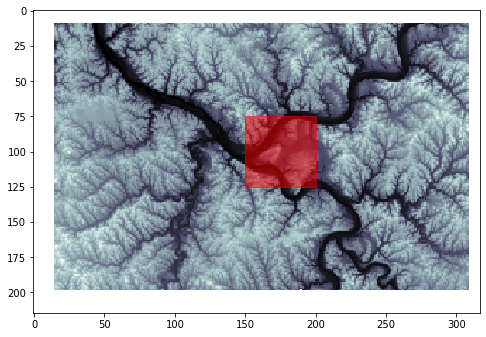

In [5]:

with rasterio.Env(CPL_CURL_VERBOSE=True):
    with rasterio.open(cog) as src:
        
        # -------------------------------------------------------
        # print some info about the raster
        print(src.meta)
        
        # -------------------------------------------------------
        # read a preview data, with its nodata mask applied
        # for the purposes of previewing, we'll read a 50:1 overview of the raster
        out_shape=(src.height//50, src.width//50)
        print(out_shape)
        arr = src.read(out_shape=out_shape, masked=True)

        # -------------------------------------------------------
        # show a the location of a window of the data
        slice_ = (slice(75, 125), slice(150, 200))
        window_slice = windows.Window.from_slices(*slice_)
        print(window_slice)
        
        # -------------------------------------------------------
        # preview the data and the window
        
        %matplotlib inline
        plt.figure(figsize=(8,8))
        plt.imshow(arr[0], cmap='bone')
        
        ax = plt.gca()
        ax.add_patch(
            Rectangle(
                (window_slice.col_off, window_slice.row_off),
                width=window_slice.width,
                height=window_slice.height,
                fill=True,
                alpha=.5,
                color="red"
            )
        )
        
        plt.show()


### read a window of data

Note that we're doing this on the full resolution raster:

Window(col_off=3000, row_off=3000, width=1000, height=1000)
(1, 1000, 1000)


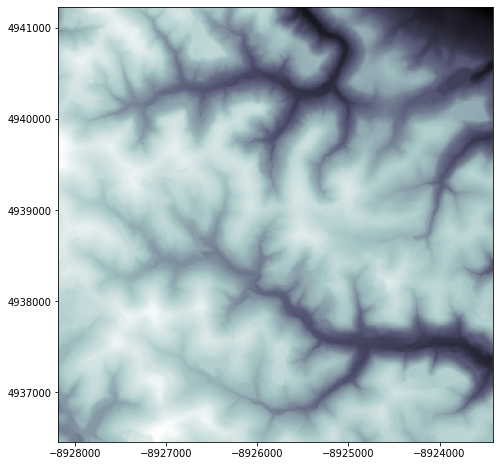

In [6]:
with rasterio.open(cog) as src:

    # -------------------------------------------------------
    # show a the location of a window of the data
    window_slice = windows.Window.from_slices(slice(3000, 4000), slice(3000, 4000))
    print(window_slice)    
    
    transform_window = windows.transform(window_slice, src.transform)
    arr = src.read(window=window_slice, masked=True)

    print(arr.shape)
    %matplotlib inline
    plt.figure(figsize=(8,8))
    #plt.imshow(arr[0], cmap='bone', transform=transform_window)
    rplot.show(
        arr[0],
        transform=transform_window,
        cmap='bone'
    )

That demonstrates the mechanics of getting the raster. Now, onto what the end-to-end workflow looks like.

## Get the parcel

This is the first actual step. We query the parcel, and get its geometry and bounding box.

In [7]:
parcels_item = alcogis.content.get(itemid=alco_parcels_id)
parcels_layer = parcels_item.layers[0]

In [8]:
parcel = parcels_layer.query(
    where="PIN='{0}'".format(alco_parcel_pin),
    outFields='MAPBLOCKLOT,CALCACREAGE,PIN',
    outSR=epsg_code
)

Note that we've requested this data in the same CRS that we know the elevation raster is stored in. It's likely going to be faster to transform the coordinates of a vector polygon than reprojecting an entire raster on the fly.

That response from the ArcGIS API for Python comes back as a a FeatureSet object. Get that response into GeoJSON (as a plain old Python dictionary).

In [9]:
parcel_geojson = json.loads(parcel.to_geojson)
parcel_geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-8901207.331349105, 4933808.8143591555],
      [-8901057.521040685, 4933951.6462321775],
      [-8900896.645649388, 4933783.1762194615],
      [-8901133.616647175, 4933731.445691026],
      [-8901207.331349105, 4933808.8143591555]]]},
   'properties': {'MAPBLOCKLOT': '49-K-62',
    'CALCACREAGE': 5.03,
    'PIN': '0049K00062000000',
    'OBJECTID': 1}}]}

Also get the bounding box. Note that this approach is unique to dealing with the ArcGIS API for Python; we could also get a bounding box by reading the GeoJSON created above into GeoPandas. 6 vs 1/2 dozen at this point.

In [10]:
parcel_bbox = list(GeoAccessor(parcel.sdf).bbox.extent)
parcel_bbox

[-8901207.331349105, 4933731.445691026, -8900896.645649388, 4933951.6462321775]

## Get the elevation data where it intersects the parcel.

First let's try using just the bounding box. In this case, the bounding box becomes the source of the `window` argument to rasterio's `.read` method after a transformation is applied.

Window(col_off=8647.846776271937, row_off=4524.251564931241, width=65.03354862122796, height=46.092957006185316)
250.74029541015625 272.7090148925781 263.25683460044223
(1, 46, 65)


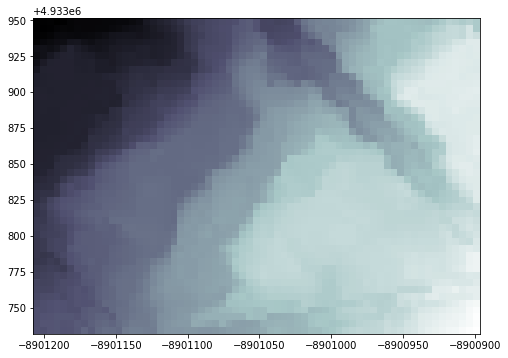

In [11]:
with rasterio.open(cog) as src:

    # show a the location of a window of the data
    window_slice = windows.from_bounds(*parcel_bbox, src.transform)
    print(window_slice)
    
    transform_window = windows.transform(window_slice, src.transform)
    
    # read the data in at just the bbox
    arr = src.read(window=window_slice, masked=True)
    
    print(arr.min(), arr.max(), arr.mean())

    print(arr.shape)
    %matplotlib inline
    plt.figure(figsize=(8,8))
    #plt.imshow(arr[0], cmap='bone', transform=transform_window)
    rplot.show(
        arr[0],
        transform=transform_window,
        cmap='bone'
    )



Next let's try using the parcel as a clipping mask:

256.4541931152344 271.5740051269531 264.0828534142446
(1, 47, 66)


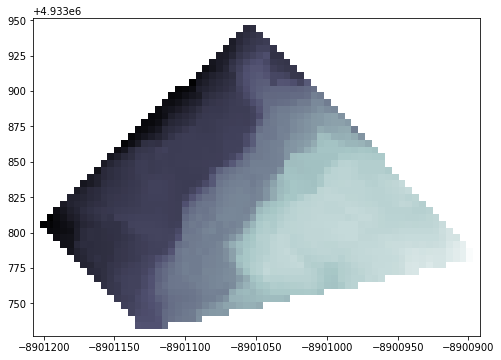

In [12]:
with rasterio.open(cog) as src:

    # read just the geometry of the parcel feature(s)
    # we only have one here, but this works on an array.
    shapes = [f["geometry"] for f in parcel_geojson['features']]
    
    # read the data in using rasterio's mask function
    arr, out_transform = rasterio.mask.mask(src, shapes, crop=True, filled=False)
    
    print(arr.min(), arr.max(), arr.mean())

    # plot the data.
    window_slice = windows.from_bounds(*parcel_bbox, out_transform)
    transform_window = windows.transform(window_slice, out_transform)

    print(arr.shape)
    %matplotlib inline
    plt.figure(figsize=(8,8))
    #plt.imshow(arr[0], cmap='bone', transform=transform_window)
    rplot.show(
        arr,
        transform=transform_window,
        cmap='bone'
    )



0.054348342 20.08185 4.651700453776891
(1, 47, 66)


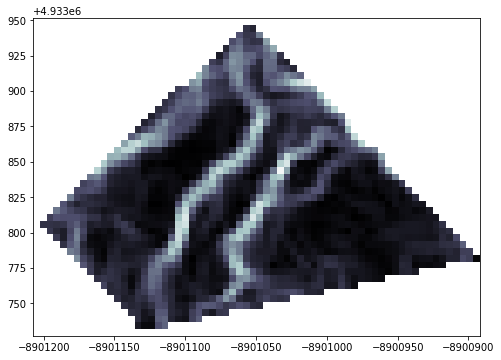

In [13]:
with rasterio.open(slope_cog) as src:

    # read just the geometry of the parcel feature(s)
    # we only have one here, but this works on an array.
    shapes = [f["geometry"] for f in parcel_geojson['features']]
    
    # read the data in using rasterio's mask function
    arr, out_transform = rasterio.mask.mask(src, shapes, crop=True, filled=False)
    
    print(arr.min(), arr.max(), arr.mean())

    # plot the data.
    window_slice = windows.from_bounds(*parcel_bbox, out_transform)
    transform_window = windows.transform(window_slice, out_transform)

    print(arr.shape)
    %matplotlib inline
    plt.figure(figsize=(8,8))
    #plt.imshow(arr[0], cmap='bone', transform=transform_window)
    rplot.show(
        arr,
        transform=transform_window,
        cmap='bone'
    )


In [14]:
average_slope = arr.mean()

In [15]:
average_slope

4.651700453776891

The above value is a parameter in a TR55 peak flow calculation.